In [1]:
import pandas as pd
import numpy as np

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter 
from scipy.spatial.distance import pdist


In [2]:
from gensim.models import Word2Vec 
import gensim

In [3]:
from transformers import AutoTokenizer, DistilBertModel, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding, DistilBertConfig, DistilBertTokenizer, DistilBertTokenizerFast, DistilBertPreTrainedModel, DistilBertForTokenClassification, DistilBertForSequenceClassification

from datasets import Dataset
from accelerate import Accelerator

In [4]:
from bs4 import BeautifulSoup
import re
from sklearn import preprocessing

In [5]:
import pandas as pd
import numpy as np
import scipy.stats as stats

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

import shap
from sklearn.neural_network import MLPClassifier, MLPRegressor

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder

# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline 

from sklearn.compose import ColumnTransformer

from sklearn.metrics import (
        classification_report, confusion_matrix, r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, accuracy_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve
) 

from sklearn.inspection import PartialDependenceDisplay, permutation_importance, partial_dependence

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, RepeatedStratifiedKFold
from xgboost import XGBClassifier, XGBRegressor, plot_importance
import xgboost as xgb
from sklearn.model_selection import cross_val_score

In [8]:

from sklearn.feature_selection import SelectFromModel

from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer 

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor


import tqdm as notebook_tqdm
from tqdm import tqdm

In [9]:
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings


In [10]:
HospitalDischargeNotes = pd.read_csv("../data/Merged_DischargeNotes_ReadmissionEnsue_sparse.csv")

In [11]:
HospitalDischargeNotes

,text,ReadmissionEnsue
0,\nName: ___ Unit No: _...,1
1,\nName: ___ Unit No: _...,1
2,\nName: ___ Unit No: _...,1
3,\nName: ___ Unit No: _...,0
4,\nName: ___ Unit No: __...,0
...,...,...
331788,\nName: ___ Unit No: ___...,1
331789,\nName: ___ Unit No: ___...,0
331790,\nName: ___ Unit No: ___\...,1
331791,\nName: ___ Unit No: ___\...,0


In [12]:
y_raw = HospitalDischargeNotes['ReadmissionEnsue']

In [13]:
X = HospitalDischargeNotes[['text']]
X

,text
0,\nName: ___ Unit No: _...
1,\nName: ___ Unit No: _...
2,\nName: ___ Unit No: _...
3,\nName: ___ Unit No: _...
4,\nName: ___ Unit No: __...
...,...
331788,\nName: ___ Unit No: ___...
331789,\nName: ___ Unit No: ___...
331790,\nName: ___ Unit No: ___\...
331791,\nName: ___ Unit No: ___\...


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y_raw, test_size = 0.2, random_state = 321, shuffle=True, stratify = y_raw)

In [15]:

X_train_tokens = X_train['text'].fillna("").apply(str.split)

X_test_tokens = X_test['text'].fillna("").apply(str.split)

w2v_model = gensim.models.Word2Vec(sentences=X_train_tokens, vector_size=100, window=10, min_count=1, workers=4)

def document_vector(doc, model):
    doc = [word for word in doc if word in model.wv]
    if len(doc) == 0:
        return np.zeros(model.vector_size)
    return np.mean(model.wv[doc], axis=0)

X_train_vec = np.vstack(X_train_tokens.apply(lambda x: document_vector(x, w2v_model)))

X_test_vec = np.vstack(X_test_tokens.apply(lambda x: document_vector(x, w2v_model)))

le = LabelEncoder()

y_train_enc = le.fit_transform(y_train)

y_test_enc = le.transform(y_test)

xgb_model = xgb.XGBClassifier( enable_categorical=True, 
                              objective='multi:softmax', 
                              num_class=len(le.classes_), 
                              n_estimators=1000,      #10000 for 91% accuracy (Macro)
                              use_label_encoder=True, 
                              eval_metric='mlogloss',
                              random_state = 535)


xgb_model.fit(X_train_vec, y_train_enc)

y_pred_enc = xgb_model.predict(X_test_vec)

y_pred = le.inverse_transform(y_pred_enc)

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:13:39] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [16]:
accuracy_score(y_test, y_pred)

0.6672041471390467

In [17]:
confusion_matrix(y_test, y_pred)

array([[16683, 12500],
       [ 9584, 27592]])

In [18]:
print(classification_report(y_test, y_pred, zero_division = 0, target_names=['No Recorded Hospital Readmission Ensued', 'Followed by Readmission to Hospital']))

                                         precision    recall  f1-score   support

No Recorded Hospital Readmission Ensued       0.64      0.57      0.60     29183
    Followed by Readmission to Hospital       0.69      0.74      0.71     37176

                               accuracy                           0.67     66359
                              macro avg       0.66      0.66      0.66     66359
                           weighted avg       0.66      0.67      0.66     66359



print(classification_report(
    y_true=tokenized_test['labels'],
    y_pred=np.argmax(trainer.predict(tokenized_test).predictions, axis=1),
    target_names=le.classes_
))

In [19]:
X_test_df = X_test[['text']].reset_index(drop=True)
X_test_df

,text
0,\nName: ___ Unit No: __...
1,\nName: ___ Unit No: ___...
2,\nName: ___ Unit No: ___...
3,\nName: ___ Unit No: ___\n \...
4,\nName: ___ Unit No: ___\n...
...,...
66354,\nName: ___ Unit No: ___\n \n...
66355,\nName: ___ Unit No: ___\n \nAdmi...
66356,\nName: ___ ___ No: ___\n \nAdmissi...
66357,\nName: ___ Unit No: ...


In [20]:
y_pred_df = pd.DataFrame(y_pred, columns=['ReadmissionEnsue'])
y_pred_df

,ReadmissionEnsue
0,1
1,0
2,0
3,1
4,0
...,...
66354,0
66355,1
66356,1
66357,1


In [21]:
Xtest_Ypred_df_to_be_exported = pd.concat([X_test_df, y_pred_df], axis=1, ignore_index=False, join='outer')
Xtest_Ypred_df_to_be_exported

,text,ReadmissionEnsue
0,\nName: ___ Unit No: __...,1
1,\nName: ___ Unit No: ___...,0
2,\nName: ___ Unit No: ___...,0
3,\nName: ___ Unit No: ___\n \...,1
4,\nName: ___ Unit No: ___\n...,0
...,...,...
66354,\nName: ___ Unit No: ___\n \n...,0
66355,\nName: ___ Unit No: ___\n \nAdmi...,1
66356,\nName: ___ ___ No: ___\n \nAdmissi...,1
66357,\nName: ___ Unit No: ...,1


In [ ]:
# Xtest_Ypred_df_to_be_exported.to_csv('../data/Xtest_Ypred_df_Word2Vec_XGBClassifier_exported.csv', index=False)

# Top Features' Importance Quantification


In [23]:
selection = SelectFromModel(xgb_model, threshold=0.0001, prefit=True)

KeyboardInterrupt: 

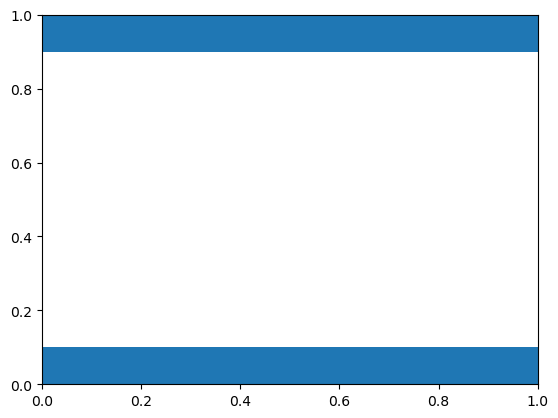

In [24]:
plot_importance_object = plot_importance(xgb_model, importance_type='gain')
plt.title('Feature Importance for Complaint Classification')
plt.show()